In [1]:
#Overarching importation
import sys, os
PROJECT_ROOT = os.path.abspath("..")  # go up one directory from notebooks/
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

In [2]:
from src.Ingest_Data import DataIngestorFactory
from src.Missing_value_handling import MissingValueHandler,FillMissingValue,DropMissingValue

#-------#
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
#---#
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score
)

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To use statistical functions
import scipy.stats as stats

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

In [3]:
#Load Data
BASE_URL = "http://127.0.0.1:8000"
TRAIN_ENDPOINT = f"{BASE_URL}/train"
TEST_ENDPOINT = f"{BASE_URL}/test"

In [4]:
df_train = DataIngestorFactory.get_data_ingestor(TRAIN_ENDPOINT).ingest(TRAIN_ENDPOINT)

2025-10-04 18:45:30 [INFO] src.Ingest_Data: Fetching data from API endpoint: http://127.0.0.1:8000/train
2025-10-04 18:45:32 [INFO] src.Ingest_Data: Received 40000 records from API


In [5]:
df_train['Target']

0       0.000
1       0.000
2       0.000
3       0.000
4       0.000
         ... 
39995   0.000
39996   0.000
39997   0.000
39998   0.000
39999   0.000
Name: Target, Length: 40000, dtype: float64

<Axes: ylabel='Target'>

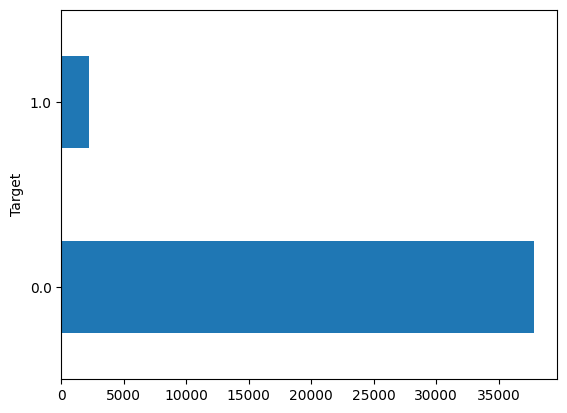

In [6]:
df_train["Target"].value_counts().plot(kind ='barh')

In [7]:
import src.scaler as scaler

In [8]:
df_scaled = scaler.SMOTEENNSampler().impute(df_train,target_col='Target')

2025-10-04 18:45:33 [INFO] src.scaler: Applying SMOTEENN hybrid resampling. Input size: (40000, 41)
2025-10-04 18:45:37 [INFO] src.scaler: SMOTEENN complete. Output size: (73091, 41)


Target
1.000    37613
0.000    35478
Name: count, dtype: int64

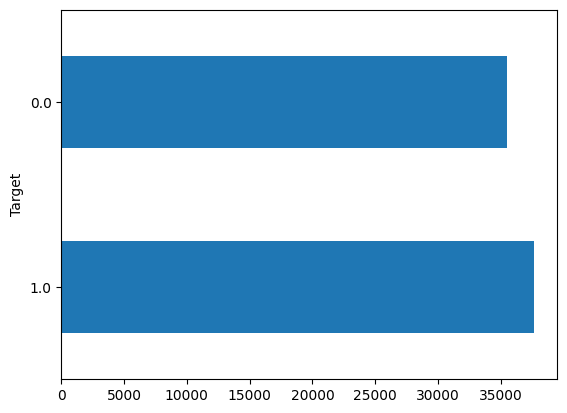

In [9]:
df_scaled["Target"].value_counts().plot(kind ='barh')
df_scaled['Target'].value_counts()

In [10]:
#Model Selection
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic Regression", LogisticRegression(solver="newton-cg", random_state=1)))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=1)))
models.append(("XGBoost", XGBClassifier(random_state=1, eval_metric="logloss", device='cpu')))

In [11]:
from src.Model_Selector import CrossValidationEvaluation,ModelEvaluator

In [12]:
strategy = CrossValidationEvaluation()
evaluator = ModelEvaluator(strategy)


In [13]:
# Evaluate models
results = evaluator.evaluate_models(models, df_scaled.drop('Target',axis = 1), df_scaled['Target'])

# # Get the best model
# best_model_name, best_model = evaluator.get_best_model(models)

# # Save the best model (correct static method call)
# model_path = ModelEvaluator.save_best_model(best_model_name, best_model)


2025-10-04 18:45:37 [INFO] src.Model_Selector: Evaluating models with maintenance cost optimization
2025-10-04 18:45:37 [INFO] src.Model_Selector: Starting CV evaluation with maintenance cost scoring


TypeError: StratifiedKFold.__init__() got an unexpected keyword argument 'n_split'